In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline


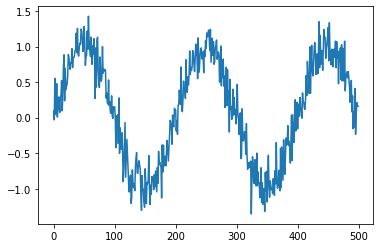

In [2]:
add_noise=1
np.random.seed(seed=5)
x=np.sin(np.linspace(-2*3.14,3*3.14,500)) 
if add_noise:
  x+=np.random.normal(0,0.2,500)
plt.plot(x)

# We received our data and we were told to transform and train a model on it for predicting/forecasting 5 days ahead values

#The baseline model we will be using is a simple Linear model using 10 previous values
Hypothesis--> AR(10) association
Transformation reuired-->
  X--> To make prediction we need 10 previous values 9th plus the 0 to 8th 
  Y--> We will be predicting the t+1th value at t

Our pipeline will be comprised of shift based transformers and model
--> We can use np.roll for shifting but we will focus on using pandas.shift as it directly creates and fill nans generated using shift


The structure flow is going to be straightforward
-> STEP 1
--> Encoding of shifts
--> Concatenating transformer and model using pipeline


--> Cross validating the models using forecast values

In [3]:
# Transformer for shifts


class MLLinTransformer(BaseEstimator, TransformerMixin):
    # def __init__(self):
    #     pass
    
    def fit(self,X,y=None):
        return self
    
    # def _check_feature_names(self):
    #     if not hasattr(self, 'featureNames_'):
    #         raise NotFittedError("FeatureNames not available yet")

    #     if len(self.featureNames_) == 0:
    #         raise ValueError("FeatureNames are empty")
    
    # def get_feature_names(self):
    #     self._check_feature_names()
    #     return self.featureNames_

class shift_transformer(MLLinTransformer):
  def __init__(self, shift,forward=False):
    self.shift=shift
    self.forward=forward
  
  # def fit(self,X,y=None):
  #   return

  def transform(self,X,y=None):
    assert(len(X.shape)==1)
    temp_x=X.copy()
    if isinstance(X,type(np.array([1]))):
      temp_x=pd.Series(X,name='dt')
    
    if self.forward:
      df_x=pd.concat(
          [temp_x.shift(-i) for i in range(1,self.shift+1)],axis=1
      ) 
      df_x.columns=['dt_t_plus_'+str(i) for i in range(1,self.shift+1)]
    else:     
      df_x=pd.concat(
          [temp_x.shift(i) for i in range(self.shift)],axis=1
      )
      df_x.columns=['dt_t_minus_'+str(i) for i in range(self.shift)]
    df_x=df_x.fillna(0)
    return df_x

In [8]:
AR=10
Forward=1

t=shift_transformer(shift=10)
xx=t.transform(x)

# t.fit(xx)
t.fit(x)
xx.head(5)


,dt_t_minus_0,dt_t_minus_1,dt_t_minus_2,dt_t_minus_3,dt_t_minus_4,dt_t_minus_5,dt_t_minus_6,dt_t_minus_7,dt_t_minus_8,dt_t_minus_9
0,0.091431,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,-0.031533,0.091431,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.552217,-0.031533,0.091431,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.047001,0.552217,-0.031533,0.091431,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.150601,0.047001,0.552217,-0.031533,0.091431,0.0,0.0,0.0,0.0,0.0


In [5]:
#Model

from sklearn.linear_model import LinearRegression
lr=LinearRegression()


model_pip=Pipeline(
    steps=[('pre_process',shift_transformer(shift=10)),
           ('mod',LinearRegression())]
)

In [6]:
# Y_data
sft_y=shift_transformer(shift=1,forward=True)
yy=sft_y.transform(x)

xx.merge(yy,left_index=True,right_index=True)
#We can perform this merging inside one of the transformer or just drop the rows from head and tail for consistency
#Else we can fill nan values as 0

# yy=yy.iloc[AR-1:,:]


model_pip.fit(x,yy)
# lr.fit(xx,yy)


Pipeline(steps=[('pre_process', shift_transformer(shift=10)),
                ('mod', LinearRegression())])

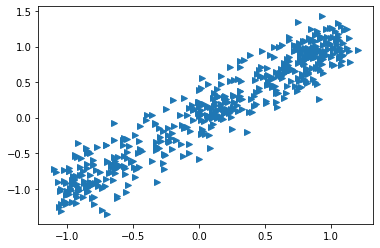

In [7]:
plt.plot(model_pip.predict(x),yy,'>')

We intend to build a forecast based function that helps to predict values that is till 5 days ahead from now
The we will have to predict the initial required data and append it to the series of X data


Structure
--> Forecast function that takes inside a model and predict the values for the coming five days
--> We will have to remove the last data from the set and append the previously predicted data inside the list





(500, 10)

In [47]:
# CV for the X data 

# Head start  has to be equal to AR that we have predicted that is 10 
# We will forecast the coming five values and compare it with the forward five values 

#Our metric of comparision will be MAE


## Defining a forecatse function 
## We can get to know about the number of initial predictors using model_coefficients values 
## But for now we will hard_code it as 10

##Structure of x is [x0,x1------x9]
##So we will have to append the new predicted values at the begining and remove the last column
def forecast(model,x,n_days=5):
  '''
  This model wil be applied on the 2-D numpy array and 
  will provide the user with five forecasted values
  '''
  #having n instances of 
  for i in range(n_days):
    pred_vals=model.predict(x)
    temp_x=x.values if not isinstance(x,type(np.array([]))) else x
    
    temp_x=np.concatenate([pred_vals.reshape(-1,1),
                           temp_x[:,1:]],axis=1                          
                          )
    x=pd.DataFrame(temp_x,columns=x.columns)
    if i==0:
      forcecast_vals=pred_vals.reshape(-1,1)
    else:
      forcecast_vals=np.concatenate([forcecast_vals,pred_vals.reshape(-1,1)],axis=1)

  return forcecast_vals

  


forecast_vals_5=forecast(model_pip.named_steps['mod'],xx,5)

forecast_vals_5.shape

(500, 5)

In [90]:
y=pd.concat([yy.shift(-i) for i in range(5)],axis=1).ffill().values
y.shape

#Lets compute a weighted mean error of forecast values wt_err= [10,7,5,3,1]
wt_err= np.array([10,7,5,3,1])
wt_err=wt_err/np.sum(wt_err)

def wt_mse(forecast_vals_5,y,wts=[]):
  err=forecast_vals_5-y#Error across 5 dimensions
  sq_err=np.power(err,2)
  mse_err=np.sum(sq_err,axis=0)
  if len(wts)>0:
    wt_mse_err=np.sum(wts*mse_err)
    return wt_mse_err
  return np.mean(mse_err)
wt_mse(forecast_vals_5,y,wt_err)

27.1859471038428

In [95]:
#Final Cross validation Function

# We will use a model train it on the current time fold and predict it on future values
#Head_start of 400 and predict and evaluate on 1 future value 

#Lets compare AR 2 with AR 10

# from collection import deafultdict

pd.concat([xx,yy],axis=1)

head_start=100

dict_models={'AR_10':model_pip,
             'AR_5': Pipeline(
    steps=[('pre_process',shift_transformer(shift=5)),
           ('mod',LinearRegression())]
                            ),
             'AR_2': Pipeline(
    steps=[('pre_process',shift_transformer(shift=2)),
           ('mod',LinearRegression())]
                            ),
             }
df_err=pd.DataFrame()
for nm,model in dict_models.items():
  val_err=[]
  for tt in range(head_start,yy.shape[0]-1):
    model.fit(x[:tt],yy[:tt])#train till this tt
    y_pred=model.predict(x[tt:])#predict on tt furthers

    err=wt_mse(y_pred,yy[tt:])#Compare on mse metric
    val_err.append(err)#Cache the result
  df_err[nm]=val_err
  



In [99]:
df_err.loc['stat',:]=df_err.mean().values
df_err

,AR_10,AR_5,AR_2
0,22.949069,22.608537,31.238979
1,22.544867,22.076535,30.003996
2,21.145638,20.782014,27.205030
3,21.106021,20.789662,27.937648
4,21.081526,20.713743,28.201941
...,...,...,...
395,0.122480,0.123051,0.144537
396,0.072517,0.072078,0.061295
397,0.033683,0.033367,0.029156
398,0.021801,0.021933,0.032139


In [78]:
#For forecating we will indivineed to work on the transformed data

# Rough Work

In [ ]:
len(pd.Series(np.arange(3)).shape)
np.array([]).copy()

np.concatenate([model_pip.predict(x).reshape(x.shape[0],1)
                 ,xx.values[:,1:]],axis=1).shape

array([], dtype=float64)

In [ ]:
isinstance(np.arange(3),type(np.array([1])))


True